In [1]:
import numpy as np
import pickle
import os
import sys
import rootpath
import pickle
import wfg
sys.path.append(rootpath.detect())

import matplotlib.pyplot as plt
import matplotlib as mpl
from testsuite.utilities import Pareto_split
from testsuite.analysis import load_all, plot_pareto_2d, plot_all_pareto_2d, PLOT_STYLE, plot_measure

In [2]:
N=200
## establish objective function
kfactor = 1
lfactor = 2
M = 5 # number of "underlying positional parameters" +1 
k = kfactor*(M-1) # position related parameers (must be devisible by M-1)
l = lfactor*2 # distance-related parameters, muist be even for WFG2 & WFG3
l = 3

n_obj = 3 # must be from 1:M 
n_dim = l+k

x_limits = np.zeros((2, n_dim))
x_limits[1] = np.array(range(1,n_dim+1))*2

# fun = BM.wfg
fun =wfg.WFG6
args = [k, n_obj] # number of objectives as argument


In [4]:
dir_path = os.path.join(rootpath.detect(), "experiments/wfg6_3obj/log_data")
result_dirs = os.listdir(dir_path)
result_dirs

['test_function_Saf_init10_MultiSurrogate_GP_ei',
 'test_function_Saf_init10_MultiSurrogate_GP_mean',
 'test_function_SmsEgo_init10_MultiSurrogate_GP_ei',
 'test_function_SmsEgo_init10_MultiSurrogate_GP_mean']

In [5]:
saf_ei_results = load_all(os.path.join(dir_path, result_dirs[0]))
saf_mu_results = load_all(os.path.join(dir_path, result_dirs[1]))
sms_ei_results = load_all(os.path.join(dir_path, result_dirs[2]))
sms_mu_results = load_all(os.path.join(dir_path, result_dirs[3]))

In [6]:
def plot_all_pareto_3d(results, axis=None, plot_indices=None):
    ys = np.array(results["y"])
    
    plot_indices = range(len(ys)) if plot_indices is None else plot_indices

    with plt.style.context(PLOT_STYLE["scatter_style"]):
        # create figure if axis is not provided.
        if axis is None:
            fig = plt.figure(figsize=[8.5, 7])
            ax = fig.gca(projection='3d')

        for i, y in enumerate(ys[plot_indices]):
            p_inds, d_inds = Pareto_split(y, return_indices=True)
            cmap = getattr(mpl.cm, PLOT_STYLE['scatter_cmaps'][i])
            colors = cmap(np.linspace(0, 1, len(y)))
            face_colors = [colors[i] if i in p_inds else "None" for i in
                           range(len(y))]
            norm = mpl.colors.Normalize(vmin=0, vmax=len(y))
            mapable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

            ax.scatter(y[:, 0], y[:, 1], y[:, 2], marker="o", edgecolors=colors,
                       linewidth=2., facecolors=face_colors)
        ax.set_xlabel("$f^1(x)$")
        ax.set_ylabel("$f^2(x)$")
        ax.set_zlabel("$f^3(x)$")
        plt.colorbar(mapable)

    if axis is not None:
        return fig
    else:
        pass


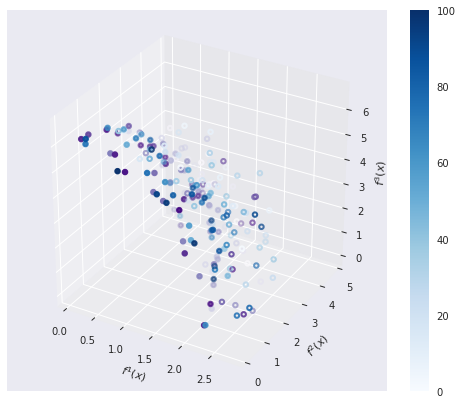

In [7]:
fig_safmu = plot_all_pareto_3d(saf_mu_results, plot_indices=[1, 2])

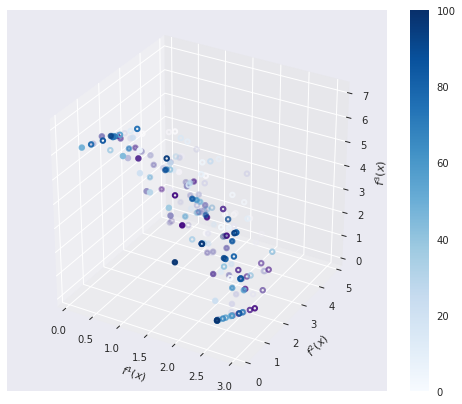

In [8]:
fig_safei = plot_all_pareto_3d(saf_ei_results, plot_indices=[1, 2])

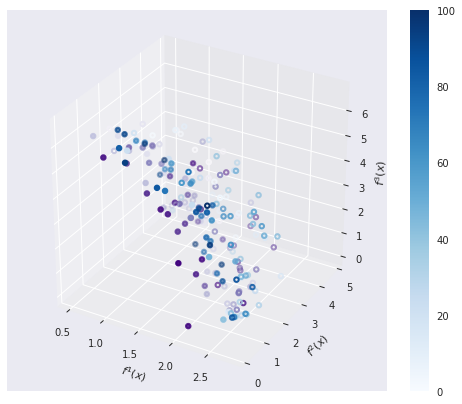

In [9]:
fig_smsmu = plot_all_pareto_3d(sms_mu_results, plot_indices=[1, 2])

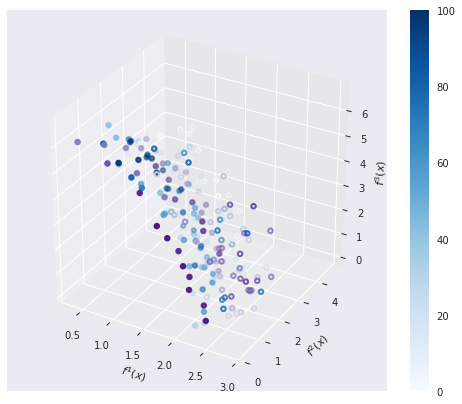

In [10]:
fig_smsei = plot_all_pareto_3d(sms_ei_results, plot_indices=[1, 2])

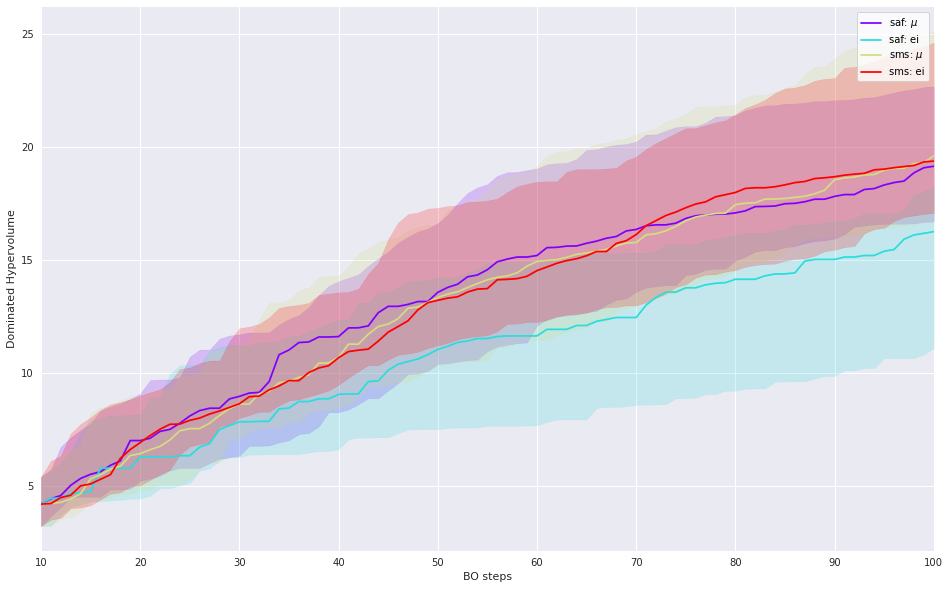

In [11]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)))

plot_measure(saf_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf: $\mu$", color=colors[0])
plot_measure(saf_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="saf: ei", color=colors[1])
plot_measure(sms_mu_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms: $\mu$", color=colors[2])
plot_measure(sms_ei_results, measure="hypervolume", axis=ax_hv, plot_individuals=False, label="sms: ei", color=colors[3])
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Dominated Hypervolume")
ax_hv.legend()

In [12]:
print(np.sum([len(errors) for errors in saf_ei_results["errors"]]), "\t",*[errors for errors in saf_ei_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in saf_mu_results["errors"]]), "\t",*[errors for errors in saf_mu_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in sms_ei_results["errors"]]), "\t",*[errors for errors in sms_ei_results["errors"] if len(errors)>0])
print(np.sum([len(errors) for errors in sms_mu_results["errors"]]), "\t",*[errors for errors in sms_mu_results["errors"] if len(errors)>0])

0 	
0 	
0 	
0 	


In [13]:
from pymoo.factory import get_performance_indicator

In [14]:
y = np.zeros((N, n_obj))
for n in range(N):
    z = wfg.random_soln(k, l, fun.__name__)
    y[n,:] = fun(z, k, n_obj)

In [19]:
y.shape

(200, 3)

In [15]:
igdp = get_performance_indicator("igd+", y)

def extract_performance(z, indicator):
    ANS  = []
    for i in range(9, len(z)):
        ans = indicator.calc(z[:i])
        ANS.append(ans)

    return ANS

In [17]:
saf_mu_results['igd'] = [extract_performance(saf_mu_results["y"][i], igdp) for i in range(len(saf_mu_results["y"]))]
saf_ei_results['igd'] = [extract_performance(saf_ei_results["y"][i], igdp) for i in range(len(saf_ei_results["y"]))]
sms_mu_results['igd'] = [extract_performance(sms_mu_results["y"][i], igdp) for i in range(len(sms_mu_results["y"]))]
sms_ei_results['igd'] = [extract_performance(sms_ei_results["y"][i], igdp) for i in range(len(sms_ei_results["y"]))]

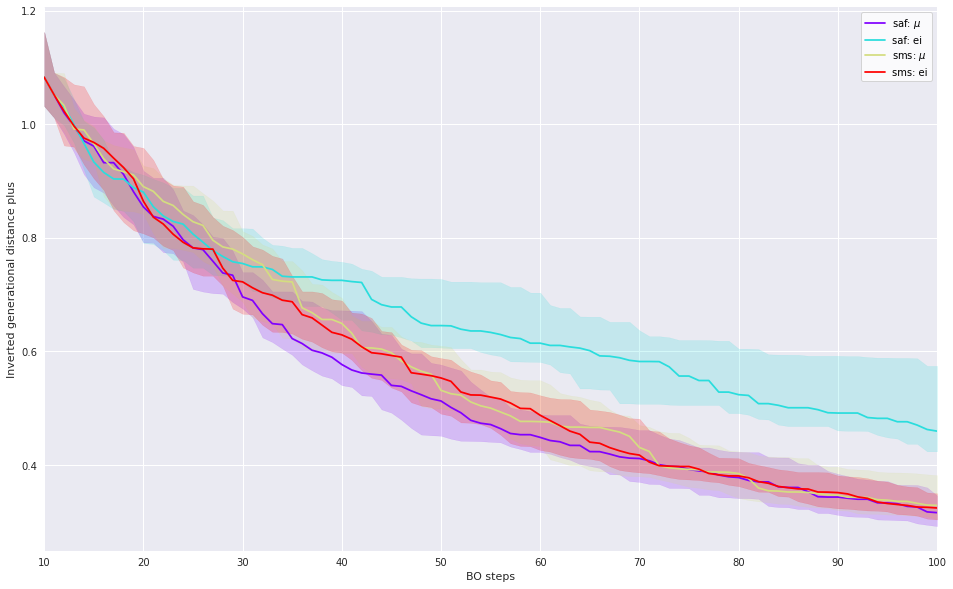

In [18]:
with plt.style.context(PLOT_STYLE["plot_style"]):
    fig_hv = plt.figure(figsize=[16, 10])
    ax_hv = fig_hv.gca()

cmap = PLOT_STYLE['plot_cmap']
colors = cmap(np.linspace(0, 1, len(result_dirs)))

plot_measure(saf_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf: $\mu$", color=colors[0])
plot_measure(saf_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="saf: ei", color=colors[1])
plot_measure(sms_mu_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms: $\mu$", color=colors[2])
plot_measure(sms_ei_results, measure="igd", axis=ax_hv, plot_individuals=False, label="sms: ei", color=colors[3])
ax_hv.set_xlim([10, 100])
ax_hv.set_xlabel("BO steps")
ax_hv.set_ylabel("Inverted generational distance plus")
ax_hv.legend()